In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

### imports

In [2]:
print(__doc__)

import time

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import entropy
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer

Automatically created module for IPython interactive environment


### utilities

In [3]:
def sigmoid(x):
    return 1 / (1 + (np.e**-x))
                
def clean_documents(docs):
    def clean_doc(doc):
        ''' remove unwanter characters line new line '''

        unwanted_chrs = [')', '(', '{', '}', '\t', '\n', '\r', "'", '"', "!"]
        for unwanted_chr in unwanted_chrs:
            doc = doc.replace(unwanted_chr, ' ')

        return doc.strip()
    
    return [clean_doc(doc) for doc in docs]

### load dataset

In [46]:
# total number of samples needed
datasize = 1000

# retrieve dataset
docs = fetch_20newsgroups(subset='train', shuffle=False, remove=('headers', 'footers', 'quotes'))
docs, old_labels, classes = docs.data[:datasize], docs.target[:datasize], docs.target_names

In [47]:
# the actual labels as np array
old_labels = np.array(old_labels)
labels = np.zeros(old_labels.shape)

# the new classes
label_classes = list(set([x.split('.')[0] for x in classes]))

# restructuring classes  from 19 to less
for label, cl in enumerate(classes):
    labels[old_labels == label] = label_classes.index(cl.split('.')[0])

In [82]:
print(f"there are {len(docs)} docs and {len(label_classes)} classes: {label_classes}")

there are 1000 docs and 7 classes: ['sci', 'misc', 'comp', 'alt', 'rec', 'soc', 'talk']


### clean dataset

In [49]:
# clean out the new line characters from text in docs
clean_docs = clean_documents(docs)
clean_docs[0]

'morgan and guzman will have era s 1 run higher than last year, and  the cubs will be idiots and not pitch harkey as much as hibbard.  castillo won t be good  i think he s a stud pitcher'

### count words

In [50]:
# initialize the count vectorizer
count_vectorizer = CountVectorizer()

# fit it to dataset
count_vectorizer.fit(clean_docs)

# create dataset
word_count = pd.DataFrame(count_vectorizer.vocabulary_, index=[0])

print("word_count shape is", word_count.shape)

word_count shape is (1, 19476)


In [51]:
word_count.head()

,morgan,and,guzman,will,have,era,run,higher,than,last,...,optilink,molested,w4wg,lastdrive,refund,lurch,conical,cornea,skysweepers,skies
0,12098,2746,8904,19022,9063,7336,15421,9215,17511,10791,...,12940,12042,18740,10792,14779,11250,5281,5505,16267,16249


### Prepare Datatset

In [52]:
# create doc count vectors
doc_vectors = count_vectorizer.transform(clean_docs).toarray()

document_word_frequency = pd.DataFrame(doc_vectors, columns=count_vectorizer.get_feature_names())
document_word_binary_frequency = (document_word_frequency > 0).astype('int')

document_word_frequency["__labels__"] = labels
document_word_binary_frequency["__labels__"] = labels

print("document_word_frequency shape is", document_word_frequency.shape)

document_word_frequency shape is (1000, 19477)


In [53]:
print(f"there are {len(clean_docs)} docs and {len(label_classes)} classes")

there are 1000 docs and 7 classes


In [54]:
document_word_frequency.head()

,00,000,0000,00000000,00000000b,00000001,00000001b,00000010,00000010b,00000011,...,zoom,zoomed,zooming,zubov,zum,zupancic,zx,zx900a,zzz,__labels__
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4.0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2.0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2.0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3.0


In [55]:
document_word_binary_frequency.head()

,00,000,0000,00000000,00000000b,00000001,00000001b,00000010,00000010b,00000011,...,zoom,zoomed,zooming,zubov,zum,zupancic,zx,zx900a,zzz,__labels__
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4.0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2.0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2.0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3.0


### Cherry pick dataset

In [56]:
# trim the data to words that spread round the corpus

#reduce freq in doc to bin value of 1 or 0
word_doc_binary_freqency = document_word_binary_frequency.drop(["__labels__"], axis='columns')

#the sum vertically of bin freq
word_doc_frequency = word_doc_binary_freqency.sum(0) 

In [71]:
topic = 0

word_topic_frequency = word_doc_binary_freqency[document_word_frequency['__labels__'] == topic].sum(0)
trust_factor = sigmoid(word_doc_frequency)

word_topic_co = (word_topic_frequency * trust_factor) / word_doc_frequency
word_topic_co.shape

(19476,)

In [72]:
word_topic_co[word_topic_co > 0].sort_values()

windows       0.016393
advance       0.031250
started       0.032258
matter        0.032258
games         0.035714
                ...   
orbit         0.999089
lunar         0.999665
escrow        0.999877
clipper       1.000000
encryption    1.000000
Length: 6758, dtype: float64

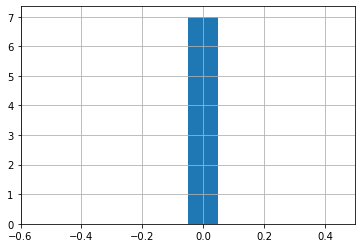

In [78]:
word = "orbit"
document_word_binary_frequency[document_word_binary_frequency[word] > 0]["__labels__"].hist(align="left")

In [80]:
document_word_frequency[document_word_binary_frequency[word] > 0][[word, "__labels__"]]

,orbit,__labels__
194,1,0.0
313,1,0.0
379,1,0.0
563,1,0.0
627,1,0.0
758,5,0.0
978,1,0.0


In [81]:
label_classes

['sci', 'misc', 'comp', 'alt', 'rec', 'soc', 'talk']